In [1]:
import os

import gym
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)

from omstang_lib.trade_gym import trade_gym

In [2]:
env = trade_gym.MarketEnv(os.path.join('Data','daily_sp500_1998-2013'), filename="table_goog.csv", scale=False)

Load file : table_goog


Annualized return: NAV[-0.024788838058855234] BASE[0.377010571390338]


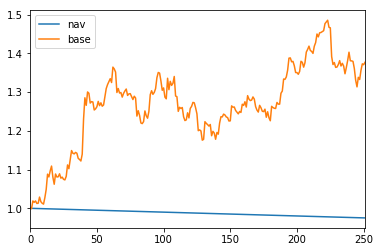

In [3]:
observation = env.reset()
done = False
navs = []

# env.info()
while not done:
    action = 1 # stay flat
    observation, reward, done, info = env.step(action)
    navs.append((info['nav'],info['base']))
    if done:
        print('Annualized return: NAV[{}] BASE[{}]'.format(navs[len(navs)-1][0]-1,navs[len(navs)-1][1]-1))
        data_plot = pd.DataFrame(navs)
        data_plot.columns = ['nav', 'base']
        data_plot.plot()

   action      navs   mkt_nav  mkt_return  sim_return  position   costs  trade
0     2.0  1.000000  1.000000   -0.011799   -0.001100       1.0  0.0011    1.0
1     2.0  0.998900  0.988201   -0.044105   -0.044205       1.0  0.0001    0.0
2     2.0  0.954743  0.944616    0.029447    0.029347       1.0  0.0001    0.0
3     2.0  0.982762  0.972432   -0.027612   -0.027712       1.0  0.0001    0.0
4     2.0  0.955527  0.945581    0.009796    0.009696       1.0  0.0001    0.0


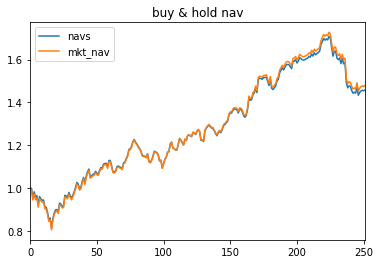

In [4]:
stayflat     = lambda o,e: 1   # stand pat
buyandhold   = lambda o,e: 2   # buy on day #1 and hold
randomtrader = lambda o,e: e.action_space.sample() # retail trader

# to run singly, we call run_strat.  we are returned a dataframe containing 
#  all steps in the sim.
bhdf = env.run_strategy(buyandhold)

print(bhdf.head())

# we can easily plot our nav in time:
bhdf.loc[:,['navs','mkt_nav']].plot(title='buy & hold nav')

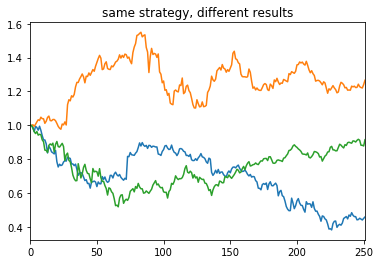

In [5]:
env.run_strategy(buyandhold).navs.plot(title='same strategy, different results')
env.run_strategy(buyandhold).navs.plot()
env.run_strategy(buyandhold).navs.plot()

In [6]:
import time
from tensorforce import Configuration
from tensorforce.agents import Agent
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym
from tensorforce.agents import DDQNAgent


class OpenAIGymCustom(OpenAIGym):
    def __init__(self, env):
        self.gym = env
        
      
env_train = trade_gym.MarketEnv(os.path.join('Data','daily_sp500_1998-2013'), filename="table_goog.csv", scale=True)
environment = OpenAIGymCustom(env_train)
config_dict = {
  "preprocessing": None,
  "exploration": {
    "type": "epsilon_decay",
    "epsilon": 1.0,
    "epsilon_final": 0.1,
    "epsilon_timesteps": 1e6
  },
  "reward_preprocessing": [
    {
      "type": "clip",
      "min": -1,
      "max": 1
    }
  ],
  "batch_size": 32,
  "memory_capacity": 10000,
  "memory": {
      "type": "replay",
      "random_sampling": True
  },
  "update_frequency": 4,
  "first_update": 50000,
  "repeat_update": 1,
  "target_update_frequency": 10000,
  "discount": 0.97,
  "learning_rate": 0.00025,
  "optimizer": {
      "learning_rate": 0.00025,
    "type": "rmsprop",
    "momentum": 0.95,
    "epsilon": 0.01
  },
  "tf_summary": None,
  "log_level": "info",
  "update_target_weight": 1.0,
  "double_dqn": False,
  "clip_loss": 0.0,
  "huber_loss": None
}

config = Configuration(**config_dict)

# Create a Proximal Policy Optimization agent
agent = DDQNAgent(
    states_spec=dict(type='float', shape=(env_train.src.data.shape[1],)),
    actions_spec=dict(type='int', num_actions=len(env_train.actions)),
    network_spec=[
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ],
    config=config
)

runner = Runner(
    agent=agent,
    environment=environment,
    repeat_actions=1
)
    
report_episodes = 1000
def episode_finished(r):
    if r.episode % report_episodes == 0:
        steps_per_second = r.timestep / (time.time() - r.start_time)
        print("=============================")
        print("Finished episode {} after {} timesteps. Steps Per Second {}".format(
            r.episode, r.episode_timestep, steps_per_second
        ))
        print("Episode reward: {}".format(r.episode_rewards[-1]))
    return True
    
runner.run(
    episodes=10000,
    max_episode_timesteps=300,
    episode_finished=episode_finished
)

print("Learning finished. Total episodes: {ep}".format(ep=runner.episode))
print("Average of last 500 rewards: {}".format(sum(runner.episode_rewards[-500:]) / 500))
print("Average of last 100 rewards: {}".format(sum(runner.episode_rewards[-100:]) / 100))

Load file : table_goog
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.


Configuration values not accessed: memory, target_update_frequency, learning_rate, tf_summary, update_target_weight, double_dqn, clip_loss


Finished episode 1000 after 252 timesteps. Steps Per Second 230.99183742971655
Episode reward: 0.05185527138653433
Finished episode 2000 after 252 timesteps. Steps Per Second 226.52003146153552
Episode reward: -0.5926036603562074
Finished episode 3000 after 252 timesteps. Steps Per Second 224.54323262249721
Episode reward: -0.42258975419559247
Finished episode 4000 after 252 timesteps. Steps Per Second 224.16228939498313
Episode reward: 0.34904027930853726
Finished episode 5000 after 252 timesteps. Steps Per Second 224.30839992003442
Episode reward: -0.4717477206486618
Finished episode 6000 after 252 timesteps. Steps Per Second 224.41993543053323
Episode reward: -0.45227614263906746
Finished episode 7000 after 252 timesteps. Steps Per Second 224.25362669083137
Episode reward: 0.004827900531422534
Finished episode 8000 after 252 timesteps. Steps Per Second 224.07457530515438
Episode reward: 0.22314747366273652
Finished episode 9000 after 252 timesteps. Steps Per Second 223.8885131384312